In [1]:
import numpy as np
import netCDF4 as nc
import auxiliary as au
import regression as reg
import datetime as dt
from matplotlib import pyplot as plt
from scipy import io
import os
import sys

########################################################################################################################
# date_cal_start = int(sys.argv[1]) # yyyymmdd
# date_cal_end = int(sys.argv[2])

# 0. read/define configuration information
# setting: file and path names of inputs
FileStnInfo = '/Users/localuser/GMET/pyGMET_NA/stnlist_whole.txt'  # station basic information (lists)
FileGridInfo = '/Users/localuser/GMET/pyGMET_NA/gridinfo_whole.nc'  # study area information
PathStn = '/Users/localuser/GMET/StnInput_daily'
# Plato
# FileStnInfo = '/home/gut428/GMET/eCAI_EMDNA/StnGridInfo/stnlist_whole.txt'  # station basic information (lists)
# FileGridInfo = '/home/gut428/GMET/eCAI_EMDNA/StnGridInfo/gridinfo_whole.nc'  # study area information
# PathStn = '/home/gut428/GMET/StnInput_daily'

# setting: start and end date
# calculation start/end date:
date_cal_start = 19900101  # yyyymmdd: start date
date_cal_end = 19900131  # yyyymmdd: end date
# station data (in PathStn) start/end date:
date_stn_start = 19790101  # yyyymmdd: start date
date_stn_end = 20181231  # yyyymmdd: end date

# setting: paramters for lag correlation of tmean_stn_daily, and cross-correlation between prcp and trange_stn_daily
windows = 1  # parameters for auto-cc t-p-cc calculation: 1 could be better than 31
lag = 1

# setting: searching nearby stations
nearstn_min = 20  # nearby stations: minimum number
nearstn_max = 30  # nearby stations: maximum number
search_radius = 400  # km. only search stations within this radius even nearstn_max cannot be reached
max_dist = 100  # max_distance in distance-based weight calculation

# setting: parameters for transforming temp to approximate normal distribution
trans_mode = 'box-cox'  # box-cox or power-law or none
trans_exp_daily = 4

# setting: overwrite flags. -1:don't save files; 0: don't overwrite files; 1 is to overwrite existing files;
ow_daily = 0
ow_weight = 0
ow_stn = 0

# setting: output files
datestr = str(date_cal_start) + '-' + str(date_cal_end)
# FileStnData = '/home/gut428/GMET/PyGMETout/stndata_' + datestr + '.npz'
# FileWeight = '/home/gut428/GMET/PyGMETout/weight.npz'
# FileRegError_daily = '/home/gut428/GMET/PyGMETout/error_' + datestr + '.npz'  # regression error at station points
# FileRegError_daily_corr = '/home/gut428/GMET/PyGMETout/error_rescorr' + datestr + '.npz'  # regression error after residual correction
# FileRegression_daily = '/home/gut428/GMET/PyGMETout/output_' + datestr + '.npz'
FileStnData = '/Users/localuser/Downloads/old/stndata_' + datestr + '.npz'
FileWeight = '/Users/localuser/Downloads/old/weight.npz'
FileRegError_daily = '/Users/localuser/Downloads/old/error_' + datestr + '.npz'  # regression error at station points
FileRegError_daily_corr = '//Users/localuser/Downloads/error_rescorr' + datestr + '.npz'
FileRegression_daily = '/Users/localuser/Downloads/output_' + datestr + '.npz'

########################################################################################################################

# 1. basic information

print('Read study area basic information')
# station location and attribute information
# stninfo: [ stations, 1/lat/lon/elev/slope_ns/slope_we ]
stnID, stninfo = au.readstnlist(FileStnInfo)
nstn = len(stnID)

# time information
if date_cal_start < date_stn_start:
    sys.exit('The calculation period is earlier than the station period')
if date_cal_end > date_stn_end:
    sys.exit('The calculation period is later than the station period')

date_cal_start2 = dt.datetime.strptime(str(date_cal_start), '%Y%m%d')
date_cal_end2 = dt.datetime.strptime(str(date_cal_end), '%Y%m%d')
ntimes = (date_cal_end2 - date_cal_start2).days + 1  # time steps to be processed

date_stn_start2 = dt.datetime.strptime(str(date_stn_start), '%Y%m%d')
loc_start = (date_cal_start2 - date_stn_start2).days  # start location in the netcdf file
loc_end = loc_start + ntimes

# seconds since 1970-1-1 0:0:0
daydiff = (date_cal_start2 - dt.datetime(1970, 1, 1)).days
seconds = (np.arange(ntimes) + daydiff) * 86400

# datelist: yyyymmdd
yyyymmdd = np.zeros(ntimes, dtype=int)
for d in range(ntimes):
    dated = date_cal_start2 + dt.timedelta(days=d)
    yyyymmdd[d] = int(dated.strftime("%Y%m%d"))
yyyymm = np.floor(yyyymmdd / 100).astype(int)
mm = np.floor(np.mod(yyyymmdd, 10000) / 100).astype(int)

########################################################################################################################

# 2. read study area basic information
print('Read study area basic information')
ncfid = nc.Dataset(FileGridInfo)
gridlat = ncfid.variables['latitude'][:].data
gridlon = ncfid.variables['longitude'][:].data
gridele = ncfid.variables['elev'][:].data
gridgns = ncfid.variables['gradient_n_s'][:].data
gridgwe = ncfid.variables['gradient_w_e'][:].data
mask = ncfid.variables['mask'][:].data  # 1: grids to be considered; the other values: invalid grids
ncfid.close()

nrows, ncols = np.shape(gridlat)
gridinfo = np.zeros([nrows, ncols, 6])
gridinfo[:, :, 0] = 1
gridinfo[:, :, 1] = gridlat
gridinfo[:, :, 2] = gridlon
gridinfo[:, :, 3] = gridele
gridinfo[:, :, 4] = gridgns
gridinfo[:, :, 5] = gridgwe
del gridlat, gridlon, gridele, gridgns, gridgwe

########################################################################################################################

# 3. read data (prcp, tmin, tmax) from station files
print('Read station precipitation and temperature data')
if os.path.isfile(FileStnData) and ow_stn != 1:
    print('FileStnData exists. loading ...')
    with np.load(FileStnData) as datatemp:
        prcp_stn_daily = datatemp['prcp_stn_daily']
        tmean_stn_daily = datatemp['tmean_stn_daily']
        trange_stn_daily = datatemp['trange_stn_daily']
        prcp_stn_climo = datatemp['prcp_stn_climo']
        tmean_stn_climo = datatemp['tmean_stn_climo']
        trange_stn_climo = datatemp['trange_stn_climo']
        prcp_stn_anom = datatemp['prcp_stn_anom']
        tmean_stn_anom = datatemp['tmean_stn_anom']
        trange_stn_anom = datatemp['trange_stn_anom']
else:
    cai_mode = 0
    prcp_stn_daily, tmean_stn_daily, trange_stn_daily, \
    prcp_stn_climo, tmean_stn_climo, trange_stn_climo, \
    prcp_stn_anom, tmean_stn_anom, trange_stn_anom \
        = au.read_station(PathStn, stnID, loc_start, loc_end, cai_mode, yyyymm)
    np.savez_compressed(FileStnData,
                        prcp_stn_daily=prcp_stn_daily, tmean_stn_daily=tmean_stn_daily, trange_stn_daily=trange_stn_daily)
    del prcp_stn_climo, tmean_stn_climo, trange_stn_climo, prcp_stn_anom, tmean_stn_anom, trange_stn_anom

########################################################################################################################

# 4. calculate auto_corr and t_p_corr
print('Calculate correlation (auto_cc and t_p_cc)')
mean_autocorr_daily, mean_tp_corr_daily = au.cc_calculate(windows, lag, prcp_stn_daily, tmean_stn_daily,
                                                          trange_stn_daily)
print('Tmean lag-1 daily autocorrelation: ', mean_autocorr_daily)
print('Trange-prcp daily correlation: ', mean_tp_corr_daily)

########################################################################################################################

# 5. find neighboring stations and calculate distance-based weights
if os.path.isfile(FileWeight) and ow_weight != 1:
    print('FileWeight exists. loading ...')
    with np.load(FileWeight) as datatemp:
        near_grid_prcpLoc = datatemp['near_grid_prcpLoc']
        near_grid_prcpWeight = datatemp['near_grid_prcpWeight']
        near_grid_tempLoc = datatemp['near_grid_tempLoc']
        near_grid_tempWeight = datatemp['near_grid_tempWeight']
        near_stn_prcpLoc = datatemp['near_stn_prcpLoc']
        near_stn_prcpWeight = datatemp['near_stn_prcpWeight']
        near_stn_prcpDist = datatemp['near_stn_prcpDist']
        near_stn_tempLoc = datatemp['near_stn_tempLoc']
        near_stn_tempWeight = datatemp['near_stn_tempWeight']
    del datatemp
else:
    near_grid_prcpLoc, near_grid_prcpDist, near_grid_prcpWeight, \
    near_grid_tempLoc, near_grid_tempDist, near_grid_tempWeight, \
    near_stn_prcpLoc, near_stn_prcpDist, near_stn_prcpWeight, \
    near_stn_tempLoc, near_stn_tempDist, near_stn_tempWeight \
        = au.station_weight(prcp_stn_daily, tmean_stn_daily, stninfo, gridinfo, mask,
                            search_radius, nearstn_min, nearstn_max, max_dist)

    # save data
    np.savez_compressed(FileWeight, near_grid_prcpLoc=near_grid_prcpLoc, near_grid_prcpDist=near_grid_prcpDist,
                        near_grid_prcpWeight=near_grid_prcpWeight, near_grid_tempLoc=near_grid_tempLoc,
                        near_grid_tempDist=near_grid_tempDist, near_grid_tempWeight=near_grid_tempWeight,
                        near_stn_prcpLoc=near_stn_prcpLoc, near_stn_prcpDist=near_stn_prcpDist,
                        near_stn_prcpWeight=near_stn_prcpWeight, near_stn_tempLoc=near_stn_tempLoc,
                        near_stn_tempDist=near_stn_tempDist, near_stn_tempWeight=near_stn_tempWeight)

########################################################################################################################

# 6. start spatial regression

########################################################################################################################

# 6.1 estimate regression error at station points
if os.path.isfile(FileRegError_daily) and ow_daily != 1:
    print('FileRegError_daily exists. loading ...')
    with np.load(FileRegError_daily) as datatemp:
        pcp_err_stn_daily = datatemp['pcp_err_stn']
        tmean_err_stn_daily = datatemp['tmean_err_stn']
        trange_err_stn_daily = datatemp['trange_err_stn']
    del datatemp
else:
    print('Estimate daily regression error at station points')
    pcp_err_stn_daily, tmean_err_stn_daily, trange_err_stn_daily = \
        reg.station_error(prcp_stn_daily, tmean_stn_daily, trange_stn_daily, stninfo, near_stn_prcpLoc,
                          near_stn_prcpWeight, near_stn_tempLoc, near_stn_tempWeight, trans_exp_daily,
                          trans_mode, nearstn_min)
    np.savez_compressed(FileRegError_daily, pcp_err_stn=pcp_err_stn_daily, tmean_err_stn=tmean_err_stn_daily,
                        trange_err_stn=trange_err_stn_daily, stninfo=stninfo)


Read study area basic information


/Users/localuser/Github/PyGMET/auxiliary.py:13: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  data = np.genfromtxt(FileStnInfo, delimiter=',', dtype=None, skip_header=2)


Read study area basic information
Read station precipitation and temperature data
FileStnData exists. loading ...
Calculate correlation (auto_cc and t_p_cc)


/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/localuser/Github/PyGMET/auxiliary.py:186: RuntimeWarning: invalid value encountered in greater
  auto_corr[abs(auto_corr) > 1] = np.nan
/Users/localuser/Github/PyGMET/auxiliary.py:187: RuntimeWarning: invalid value encountered in greater
  t_p_corr[abs(t_p_corr) > 1] = np.nan


Tmean lag-1 daily autocorrelation:  0.5453628561117131
Trange-prcp daily correlation:  -0.21587901622136896
FileWeight exists. loading ...
FileRegError_daily exists. loading ...


In [2]:
# 6.2 estimate new errors after carrying out residual correction (leave-one-out)
if os.path.isfile(FileRegError_daily_corr) and ow_daily != 1:
    print('FileRegError_daily_corr exists. loading ...')
    with np.load(FileRegError_daily) as datatemp:
        pcp_err_stn_daily_corr = datatemp['pcp_err_stn']
        tmean_err_stn_daily_corr = datatemp['tmean_err_stn']
        trange_err_stn_daily_corr = datatemp['trange_err_stn']
    del datatemp
else:
    print('Estimate daily regression error after residual correction at station points')
    dori = au.transform(prcp_stn_daily,trans_exp_daily,trans_mode)
    dreg = dori + pcp_err_stn_daily
    pcp_err_stn_daily_corr = reg.error_after_residualcorrection(dori, dreg, near_stn_prcpLoc, near_stn_prcpWeight)
    dori = tmean_stn_daily
    dreg = dori + tmean_err_stn_daily
    tmean_err_stn_daily_corr = reg.error_after_residualcorrection(dori, dreg, near_stn_tempLoc, near_stn_tempWeight)
    dori = trange_stn_daily
    dreg = dori + trange_err_stn_daily
    trange_err_stn_daily_corr = reg.error_after_residualcorrection(dori, dreg, near_stn_tempLoc, near_stn_tempWeight)
    del dori, dreg

Estimate daily regression error after residual correction at station points


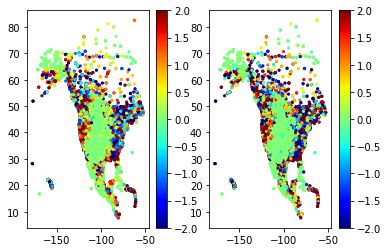

In [3]:
pcp_err_stn_daily_corr[pcp_err_stn_daily_corr==-999] = np.nan
pcp_err_stn_daily[pcp_err_stn_daily==-999] = np.nan
plt.subplot(121)
plt.scatter(stninfo[:,2],stninfo[:,1],5,pcp_err_stn_daily[:,0],cmap='jet')
plt.colorbar()
plt.clim([-2,2])
plt.subplot(122)
plt.scatter(stninfo[:,2],stninfo[:,1],5,pcp_err_stn_daily_corr[:,0],cmap='jet')
plt.colorbar()
plt.clim([-2,2])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


195578 314284
0.0 0.6775484902149793
0.019661726218550907 -279.2104549140879


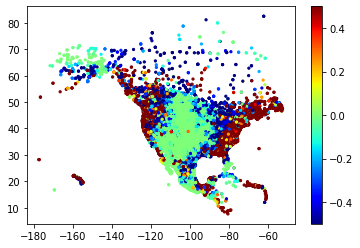

In [11]:
diff=np.abs(pcp_err_stn_daily_none) - np.abs(pcp_err_stn_daily)
print(np.sum(diff>0),np.sum(diff<0))
print(np.nanmedian(diff),np.nanmean(diff))
print(np.nanmean(tmean_err_stn_daily_corr),np.nanmean(tmean_err_stn_daily))
plt.scatter(stninfo[:,2],stninfo[:,1],5,diff[:,0],cmap='jet')
plt.colorbar()
plt.clim([-0.5,0.5])

In [5]:
dori = trange_stn_daily
pori1=dori+trange_err_stn_daily
pori2=dori+trange_err_stn_daily_corr
print(np.corrcoef(dori[1100,:],pori1[1100,:]))
print(np.corrcoef(dori[1100,:],pori2[1100,:]))
print(np.mean(dori[1100,:]),np.mean(pori1[1100,:]),np.mean(pori2[1100,:]))

[[1.        0.9556479]
 [0.9556479 1.       ]]
[[1.         0.92825318]
 [0.92825318 1.        ]]
9.821955527028729 10.241869223109989 9.997443113052173


In [10]:
pcp_err_stn_daily_none, tmean_err_stn_daily_none, trange_err_stn_daily_none = \
        reg.station_error(prcp_stn_daily, tmean_stn_daily, trange_stn_daily, stninfo, near_stn_prcpLoc,
                          near_stn_prcpWeight, near_stn_tempLoc, near_stn_tempWeight, trans_exp_daily,
                          'none', nearstn_min)

Current time: 0 Total times: 31
Current time: 1 Total times: 31
Current time: 2 Total times: 31
Current time: 3 Total times: 31
Current time: 4 Total times: 31
Current time: 5 Total times: 31
Current time: 6 Total times: 31
Current time: 7 Total times: 31
Current time: 8 Total times: 31
Current time: 9 Total times: 31
Current time: 10 Total times: 31
Current time: 11 Total times: 31
Current time: 12 Total times: 31
Current time: 13 Total times: 31
Current time: 14 Total times: 31
Current time: 15 Total times: 31
Current time: 16 Total times: 31
Current time: 17 Total times: 31
Current time: 18 Total times: 31
Current time: 19 Total times: 31
Current time: 20 Total times: 31
Current time: 21 Total times: 31
Current time: 22 Total times: 31
Current time: 23 Total times: 31
Current time: 24 Total times: 31
Current time: 25 Total times: 31
Current time: 26 Total times: 31
Current time: 27 Total times: 31
Current time: 28 Total times: 31
Current time: 29 Total times: 31
Current time: 30 Tot

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


339169 426688
-0.00390625 0.03677293993832035
0.02592551 -0.6296193783143597


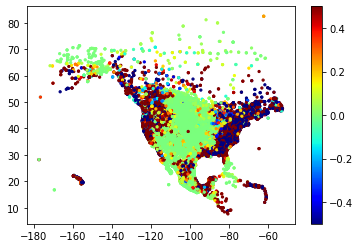

In [15]:
dori = au.transform(prcp_stn_daily,trans_exp_daily,trans_mode)
pcpstnreg = au.retransform(dori+pcp_err_stn_daily,trans_exp_daily,trans_mode)
pcp_err_stn_daily_none[pcp_err_stn_daily_none==-999]=np.nan
diff=np.abs(pcp_err_stn_daily_none) - np.abs(pcpstnreg-prcp_stn_daily)
print(np.sum(diff>0),np.sum(diff<0))
print(np.nanmedian(diff),np.nanmean(diff))
print(np.nanmean(pcp_err_stn_daily_none),np.nanmean(pcpstnreg-prcp_stn_daily))
plt.scatter(stninfo[:,2],stninfo[:,1],5,diff[:,0],cmap='jet')
plt.colorbar()
plt.clim([-0.5,0.5])

In [18]:
err1=np.zeros([nstn,4])
err2=np.zeros([nstn,4])
for i in range(nstn):
    pre=pcpstnreg[i,:]
    obs=prcp_stn_daily[i,:]
    err1[i,:]=au.metric(obs, pre)
    pre=pcp_err_stn_daily_none[i,:]+prcp_stn_daily[i,:]
    obs=prcp_stn_daily[i,:]
    err2[i,:]=au.metric(obs, pre)

/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:390: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/localuser/Github/PyGMET/auxiliary.py:150: RuntimeWarning: Mean of empty slice
  metout[1] = np.nanmean(pre - obs)  # ME
/Users/localuser/Github/PyGMET/auxiliary.py:151: RuntimeWarning: Mean of empty slice
  metout[2] = np

In [20]:
print(np.nanmedian(err1,axis=0),np.nanmedian(err2,axis=0))

[ 0.85608133 -0.35364552  0.80827656  2.05541511] [0.85477979 0.02610034 0.88403432 1.91284169]


In [21]:
import calendar
calendar.monthrange(2018, 9+1[1]

(0, 31)